In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mlflow
import mlflow.keras

In [2]:
# Set MLflow tracking URI (local or remote server)
mlflow.set_tracking_uri("http://localhost:5000")  # Default MLflow server

In [3]:
# Load Processed Data (`train_data.csv`)
file_path = './rossmann-store-sales/train_data.csv'  # Processed dataset (before scaling)

In [4]:
data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date", low_memory=False)

In [5]:
# Step 1: Aggregate Sales Data for Time-Series Analysis
sales_data = data.groupby("Date")["Sales"].sum().to_frame()

In [6]:
# Step 2: Check for Stationarity Using ADF Test
result = adfuller(sales_data["Sales"])

In [7]:
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.761614524595634
p-value: 6.436731330558783e-05


In [8]:
# Step 3: Apply Differencing If Needed
if result[1] > 0.05:  # If p-value > 0.05, the data is not stationary
    sales_data["Sales_diff"] = sales_data["Sales"].diff()
    sales_data.dropna(inplace=True)  # Drop NaN values after differencing
    column_to_plot = "Sales_diff"
    print("✅ Data was differenced to make it stationary.")
else:
    column_to_plot = "Sales"  # Use original data if already stationary
    print("✅ Data is already stationary. No differencing needed.")

✅ Data is already stationary. No differencing needed.


In [9]:
sales_data

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593
...,...
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962


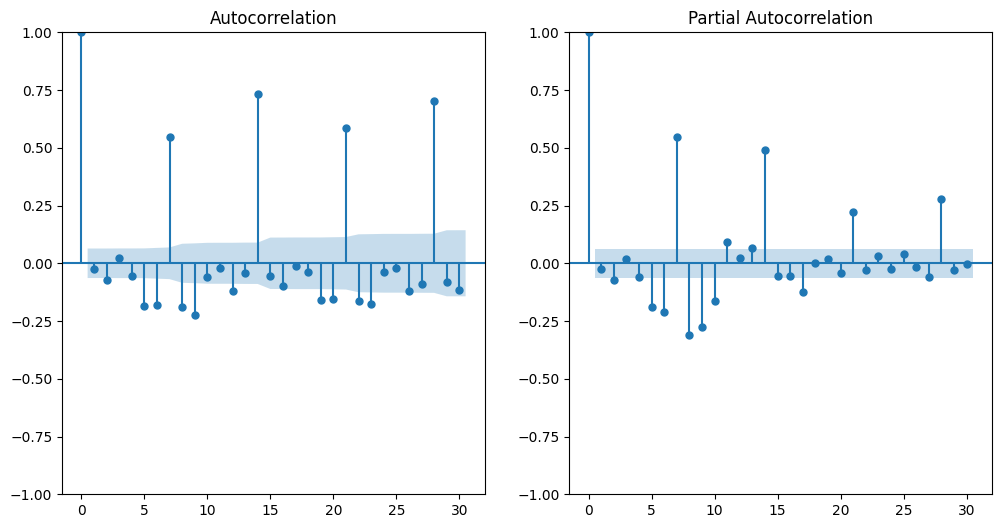

In [10]:
# ✅ Step 4: Plot ACF & PACF
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(sales_data[column_to_plot].dropna(), lags=30, ax=plt.gca())  # ACF plot
plt.subplot(1, 2, 2)
plot_pacf(sales_data[column_to_plot].dropna(), lags=30, ax=plt.gca())  # PACF plot
plt.show()

In [11]:
# Step 5: Convert Time Series Data to Supervised Learning
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [12]:
# Scale Sales Data to (-1, 1) Range
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(sales_data["Sales"].values.reshape(-1, 1))

In [14]:
# Create Sliding Window Sequences
time_steps = 45  # Use past 45 days for prediction
X, y = create_sequences(scaled_sales, time_steps)

In [15]:
# Split Data into Training & Testing
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [16]:
# Reshape X for LSTM (Samples, TimeSteps, Features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# ✅ Define LSTM Model Properly
lstm_model = Sequential([
    Input(shape=(time_steps, 1)),  # Define input shape explicitly
    LSTM(units=50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, activation='relu'),
    Dropout(0.2),
    Dense(units=1)  # Single output for sales prediction
])

In [20]:
# Compile the Model
lstm_model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
# Print Model Summary to Verify
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 45, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the Model
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1779 - val_loss: 0.1770
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1619 - val_loss: 0.1743
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1616 - val_loss: 0.1711
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1662 - val_loss: 0.1700
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1641 - val_loss: 0.1695
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1542 - val_loss: 0.1610
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1545 - val_loss: 0.1485
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1335 - val_loss: 0.1353
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1392 - val_loss: 0.1300
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1259 - val_loss: 0.1225
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1207 - val_loss: 0.1201
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1

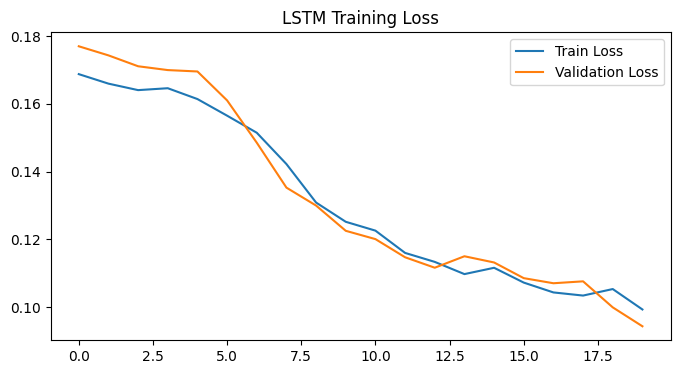

In [23]:
# Plot Training Loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.title("LSTM Training Loss")
plt.show()

In [24]:
# Step 8: Make Predictions
y_pred = lstm_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [25]:
y_pred

array([[-0.03440096],
       [ 0.01402752],
       [-0.02635174],
       [-0.14149226],
       [-0.30256677],
       [-0.47684318],
       [-0.64221734],
       [ 0.01884231],
       [-0.05278066],
       [-0.124539  ],
       [-0.22177906],
       [-0.3453169 ],
       [-0.4744533 ],
       [-0.59436995],
       [ 0.09288555],
       [ 0.0993153 ],
       [ 0.0438317 ],
       [-0.07738036],
       [-0.24007179],
       [-0.42467758],
       [-0.6057632 ],
       [ 0.00492406],
       [-0.0787831 ],
       [-0.15505871],
       [-0.25960803],
       [-0.38479635],
       [-0.5105169 ],
       [-0.625668  ],
       [ 0.08067361],
       [ 0.14617804],
       [ 0.11376514],
       [-0.02036137],
       [-0.20512041],
       [-0.41330573],
       [-0.6197144 ],
       [-0.03246585],
       [-0.09675446],
       [-0.16873702],
       [-0.27205402],
       [-0.39727014],
       [-0.5249388 ],
       [-0.637443  ],
       [ 0.09396102],
       [ 0.15851481],
       [ 0.11916696],
       [-0

In [26]:
# Convert Predictions Back to Original Scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [27]:
y_pred_original,y_test_original

(array([[7593331.5],
        [7969289. ],
        [7655819. ],
        [6761965. ],
        [5511518.5],
        [4158583.5],
        [2874758. ],
        [8006667.5],
        [7450647. ],
        [6893575.5],
        [6138686. ],
        [5179642.5],
        [4177136.2],
        [3246204.8],
        [8581476. ],
        [8631392. ],
        [8200664. ],
        [7259676. ],
        [5996677. ],
        [4563553. ],
        [3157757. ],
        [7898618. ],
        [7248786. ],
        [6656646.5],
        [5845014. ],
        [4873157. ],
        [3897169.2],
        [3003233. ],
        [8486673. ],
        [8995194. ],
        [8743568. ],
        [7702323. ],
        [6268009.5],
        [4651834.5],
        [3049452. ],
        [7608354. ],
        [7109271.5],
        [6550459.5],
        [5748393.5],
        [4776321.5],
        [3785209.2],
        [2911821.8],
        [8589826. ],
        [9090967. ],
        [8785503. ],
        [7689918.5],
        [6253806. ],
        [4645

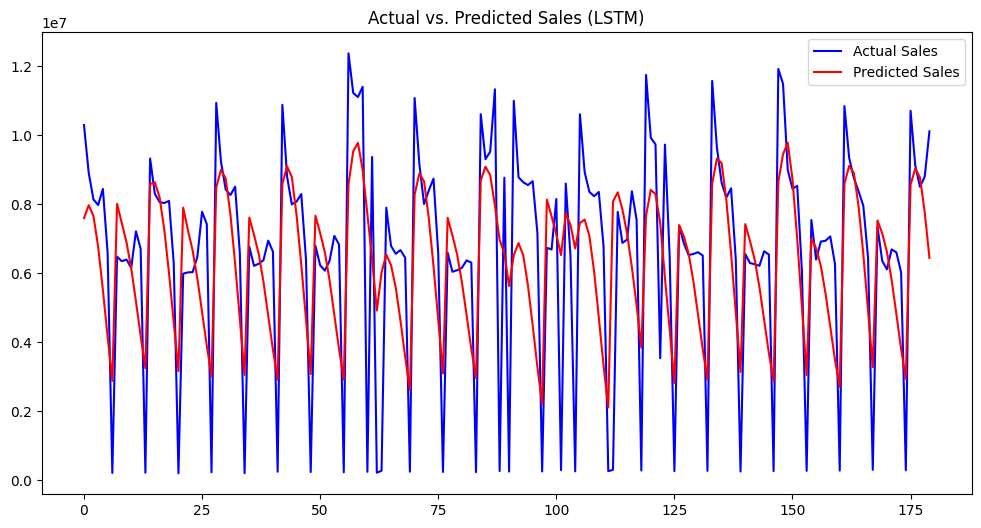

In [28]:
# Plot Actual vs. Predicted Sales
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Sales", color="blue")
plt.plot(y_pred_original, label="Predicted Sales", color="red")
plt.legend()
plt.title("Actual vs. Predicted Sales (LSTM)")
plt.show()

In [35]:
print("LSTM Model Training & Prediction Completed Successfully!")

LSTM Model Training & Prediction Completed Successfully!


In [36]:
# Save the trained LSTM model as .keras file
lstm_model.save('./rossmann-store-sales/lstm_model_final.keras')

print("LSTM Model saved as lstm_model_final.keras")

LSTM Model saved as lstm_model_final.keras


-----------------------------------------------------

***Serving Predictions Using MLflow***

In [37]:
# Log the trained model to MLflow
with mlflow.start_run():
    mlflow.keras.log_model(lstm_model, "lstm_model")
    mlflow.log_param("epochs", 20)
    mlflow.log_param("batch_size", 16)

    print("LSTM Model logged to MLflow successfully!")

2025/03/20 17:50:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/03/20 17:50:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LSTM Model logged to MLflow successfully!
🏃 View run valuable-dove-391 at: http://localhost:5000/#/experiments/0/runs/a31830d84e1448638f75a08bfbb19b13
🧪 View experiment at: http://localhost:5000/#/experiments/0
